# 🚗 Project Summary: Predicting Daily Car Accidents

**Our project is to build a linear regression model to predict how many car accidents happen on a given day based on date-related and weather-related features.**

 

## Importing Packages
We use the same modules as we would use for any problem working with data. We have numpy and pandas to work with numbers and data, and we have seaborn and matplotlib to visualize data. We would also like to filter out unnecessary warnings.

In [1]:
import os
import re
import gc

from pytz import timezone
from datetime import datetime
import holidays

import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

-----------------------------------------------------------------------------------------------------------------------------------------

## Loading and Inspecting Data
With various Pandas functions, we load our training and test data set as well as inspect it to get an idea of the data we're working with. Wow! That is a large data set; just take a look at its shape. We're going to have to understand our data before modelling. 

In [2]:
# train_df = pd.read_csv('/kaggle/input/us-accidents/US_Accidents_March23.csv')

print(os.listdir('/kaggle/input/')) #us-accidents

dataset_path = "/kaggle/input/US_Accidents_March23.csv"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"File not found at {dataset_path}. Please ensure the dataset is correctly attached.") 

train_df = pd.read_csv(dataset_path)

['US_Accidents_March23.csv']


In [3]:
train_df.shape

(7728394, 46)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [5]:
train_df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


| Feature             | Type               | How to Get It                                             | Why It's Useful                                          |
|:--------------------|:-------------------|:----------------------------------------------------------|:---------------------------------------------------------|
| day_of_week         | Categorical (0–6)  | From Start_Time                                           | Accident patterns vary by weekday                        |
| month               | Categorical (1–12) | From Start_Time                                           | Seasonality can affect accident rates                    |
| is_weekend          | Binary (0/1)       | Based on day_of_week                                      | Traffic differs on weekends                              |
| is_night            | Float              | Convert Sunrise_Sunset to 1=Night, 0=Day, take daily mean | More night driving may increase accidents                |
| traffic_signal_rate | Float              | Daily mean of Traffic_Signal                              | More signals may relate to more urban areas/accidents    |
| station_rate        | Float              | Daily mean of Station                                     | May indicate areas of congestion                         |
| severity_avg        | Float              | Daily mean of Severity                                    | Gives a sense of how severe accidents are on average     |
| distance_avg        | Float              | Daily mean of Distance(mi)                                | Longer accidents may involve highways                    |
| source_diversity    | Integer            | Number of unique Source values per day                    | More sources might mean better coverage (urban vs rural) |
| accident_count      | Integer (target)   | Count of accidents per day                                | This is your prediction target                           |

-----------------------------------------------------------------------------------------------------------------------------------------

## Data Cleaning

### Dropping columns irrelevant to our investigation

In [6]:
train_df = train_df.drop(['Start_Lat','Start_Lng','End_Lat','End_Lng','Description','Street',
                          'City','County','Zipcode','Country','Timezone','Airport_Code',
                          'Weather_Timestamp','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], axis=1)

### Source :
according to documentation the availble sources are: MapQuest, Bing, Here, INRIX, TomTom, WeatherBug, Navbugsince we only have Source1, Source2, Source3 in the Source column and we don't know which is which, we will only use the most common source which is "Source1"

In [7]:
print(train_df['Source'].value_counts().sort_index())
my_df = train_df[train_df['Source'] == train_df['Source'].value_counts().idxmax()].reset_index(drop=True)

Source
Source1    4325632
Source2    3305373
Source3      97389
Name: count, dtype: int64


In [8]:
# releases resources of unused data frames, Kaggle notebookes are limited to ~30GB 
del train_df
gc.collect()

4

### Start_Time (Accident_Time) :
**We decided to filter out the rows with badly formatted Start_Time.** we need alot of information about the date and time of day, we have enough data without it. the valid data is 75%

In [9]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'], errors='coerce')
print("Total rows : ", my_df.shape[0])
print("Valid rows : ", my_df[my_df['Start_Time'].notna()].shape[0])
my_df = my_df[my_df['Start_Time'].notna()]

Total rows :  4325632
Valid rows :  3582466


In [10]:
my_df.shape # (7728394, 46)

(3582466, 30)

-----------------------------------------------------------------------------------------------------------------------------------------

## EDA

-----------------------------------------------------------------------------------------------------------------------------------------

### Tempreture information 
Convert from Fahrenheit to Celsius so it will be easier for us to understand and split into bins

In [11]:
my_df['Temperature(C)'] = (my_df['Temperature(F)'] - 32) * 5.0 / 9.0
my_df = my_df.drop(['Temperature(F)'], axis=1)
bins = [-50, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['< -20°C', '-20–-10°C', '-10–0°C', '0–10°C', '10–20°C', '20–30°C', '30–40°C', '40–50°C', '50+°C']
my_df['Temperature_Range'] = pd.cut(my_df['Temperature(C)'], bins=bins, labels=labels, right=False)
print (my_df['Temperature_Range'].value_counts().sort_index())

Temperature_Range
< -20°C         6142
-20–-10°C      36399
-10–0°C       225112
0–10°C        656921
10–20°C      1112294
20–30°C      1162579
30–40°C       289340
40–50°C         5275
50+°C             23
Name: count, dtype: int64


In [12]:
my_df['Wind_Chill(C)'] = (my_df['Wind_Chill(F)'] - 32) * 5.0 / 9.0
my_df = my_df.drop(['Wind_Chill(F)'], axis=1)
bins = [-50, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['< -20°C', '-20–-10°C', '-10–0°C', '0–10°C', '10–20°C', '20–30°C', '30–40°C', '40–50°C', '50+°C']
my_df['Wind_Chill_Range'] = pd.cut(my_df['Wind_Chill(C)'], bins=bins, labels=labels, right=False)
print (my_df['Wind_Chill_Range'].value_counts().sort_index())

Wind_Chill_Range
< -20°C       25596
-20–-10°C     73926
-10–0°C      288655
0–10°C       489047
10–20°C      948017
20–30°C      993425
30–40°C      246846
40–50°C        4281
50+°C            18
Name: count, dtype: int64


-----------------------------------------------------------------------------------------------------------------------------------------

### Distance is the approximate length of the road affected by the accident, measured in miles.
We convert disntace information from miles to kilometers so it will be easier for us to understand and split into bins

In [13]:
print(my_df['Distance(mi)'].value_counts().sort_index())

my_df['Distance(km)'] = my_df['Distance(mi)'] * 1.60934
my_df = my_df.drop(['Distance(mi)'], axis=1)

my_df['Log_Distance'] = np.log1p(my_df['Distance(km)'])  # reduce skew and improve model performance

bins_km = [0, 5, 10, 25, 50, float('inf')]
labels_km = ['0–5 km', '5-10 km', '10–25 km', '25-50 km', '50+ km']
my_df['Distance_Range'] = pd.cut(my_df['Distance(km)'], bins=bins_km, labels=labels_km, right=False)
print(my_df['Distance_Range'].value_counts().sort_index())


Distance(mi)
0.000      401313
0.001        5581
0.002        3000
0.003        3920
0.004        5540
            ...  
150.138         1
151.525         1
152.543         1
153.663         1
155.186         1
Name: count, Length: 17850, dtype: int64
Distance_Range
0–5 km      3383009
5-10 km      146972
10–25 km      46999
25-50 km       4190
50+ km         1296
Name: count, dtype: int64


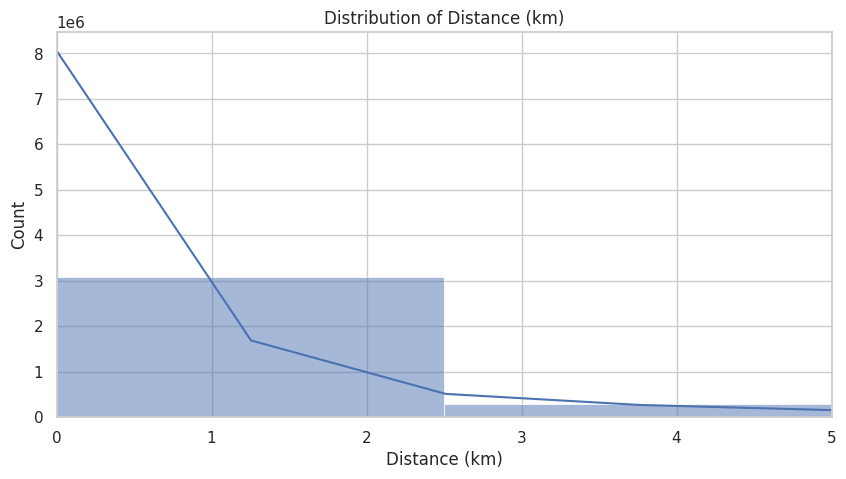

count    3.582466e+06
mean     1.297619e+00
std      2.893569e+00
min      0.000000e+00
25%      9.977908e-02
50%      4.361311e-01
75%      1.382423e+00
max      2.497470e+02
Name: Distance(km), dtype: float64


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(my_df['Distance(km)'], bins=100, kde=True)
plt.title('Distribution of Distance (km)')
plt.xlabel('Distance (km)')
plt.xlim(0, 5)  # zoom in to the main range of 0–5 km
plt.grid(True)
plt.show()
print(my_df['Distance(km)'].describe())

### Incident duration : how long the incident impacted the area, measured in hours
Very Short (0–0.5 hours), Short	(0.5–1 hour ), Medium (1–2 hours), Long	(2–4 hours), Very Long	(4+ hours)

In [15]:
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'], errors='coerce')
my_df['End_Time'] = pd.to_datetime(my_df['End_Time'], errors='coerce')
my_df['Incident_Duration_Hours'] = ((my_df['End_Time'] - my_df['Start_Time']).dt.total_seconds() / 3600).round(2)

bins = [0, 0.5, 1, 2, 4, float('inf')]
labels = ['Very Short (0–0.5 hours)', 'Short (0.5–1 hour )', 'Medium (1–2 hours)', 'Long (2–4 hours)', 'Very Long (4+ hours)']
my_df['Incident_Duration_Bin'] = pd.cut(my_df['Incident_Duration_Hours'], bins=bins, labels=labels, right=False)

print(my_df['Incident_Duration_Bin'].value_counts().sort_index())

Incident_Duration_Bin
Very Short (0–0.5 hours)     369508
Short (0.5–1 hour )          397632
Medium (1–2 hours)          1101547
Long (2–4 hours)             955409
Very Long (4+ hours)         758370
Name: count, dtype: int64


In [16]:
# TODO : DISPLAY
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Distance(km)', y='Incident_Duration_Hours', data=my_df, alpha=0.3)
# plt.xlabel('Distance Affected (km)')
# plt.ylabel('Incident Duration (hours)')
# plt.title('Distance vs. Duration')
# plt.grid(True)
# plt.xlim(0, 5)
# plt.ylim(0, 10)
# plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------

### Weather Conditions
we simplify weather condition description by mapping to common wording so we can created columns to include in the regression


In [17]:
print(my_df['Weather_Condition'].unique())

my_df['Weather_Simplified'] = 'Other'

my_df.loc[my_df['Weather_Condition'].str.contains(r'Snow|Sleet|Hail|Ice', case=False, na=False), 'Weather_Simplified'] = 'Snow'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Rain|Precipitation|Drizzle', case=False, na=False), 'Weather_Simplified'] = 'Rain'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Thunder|T-Storm', case=False, na=False), 'Weather_Simplified'] = 'Thunder'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Cloud|Overcast', case=False, na=False), 'Weather_Simplified'] = 'Cloudy'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Fog|Haze|Mist', case=False, na=False), 'Weather_Simplified'] = 'Fog'
my_df.loc[my_df['Weather_Condition'].str.contains(r'Dust|Sand', case=False, na=False), 'Weather_Simplified'] = 'Dust'
my_df.loc[my_df['Weather_Condition'].str.contains('Smoke', case=False, na=False), 'Weather_Simplified'] = 'Smoke'
my_df.loc[my_df['Weather_Condition'].str.contains('Fair', case=False, na=False), 'Weather_Simplified'] = 'Fair'
my_df.loc[my_df['Weather_Condition'].str.contains('Wintry', case=False, na=False), 'Weather_Simplified'] = 'Wintry'
my_df.loc[my_df['Weather_Condition'].str.contains('Squalls', case=False, na=False), 'Weather_Simplified'] = 'Squalls'
my_df = my_df.drop(['Weather_Condition'], axis=1)

print(my_df['Weather_Simplified'].value_counts().head(20))

['Light Rain' 'Overcast' 'Mostly Cloudy' 'Snow' 'Light Snow' 'Cloudy' nan
 'Scattered Clouds' 'Clear' 'Partly Cloudy' 'Light Freezing Drizzle'
 'Light Drizzle' 'Haze' 'Rain' 'Heavy Rain' 'Fair' 'Drizzle' 'Fog'
 'Thunderstorms and Rain' 'Patches of Fog' 'Light Thunderstorms and Rain'
 'Mist' 'Rain Showers' 'Light Rain Showers' 'Heavy Drizzle' 'Smoke'
 'Light Freezing Fog' 'Light Freezing Rain' 'Blowing Snow'
 'Heavy Thunderstorms and Rain' 'Heavy Snow' 'Snow Grains' 'Squalls'
 'Light Fog' 'Shallow Fog' 'Thunderstorm' 'Light Ice Pellets' 'Thunder'
 'Thunder in the Vicinity' 'Fair / Windy' 'Light Rain with Thunder'
 'Heavy Thunderstorms and Snow' 'Light Snow Showers' 'Cloudy / Windy'
 'Ice Pellets' 'N/A Precipitation' 'Light Thunderstorms and Snow'
 'T-Storm' 'Rain / Windy' 'Wintry Mix' 'Partly Cloudy / Windy'
 'Heavy T-Storm' 'Sand' 'Light Rain / Windy' 'Widespread Dust'
 'Mostly Cloudy / Windy' 'Blowing Dust / Windy' 'Blowing Dust'
 'Volcanic Ash' 'Freezing Rain / Windy' 'Small Hail' 'W

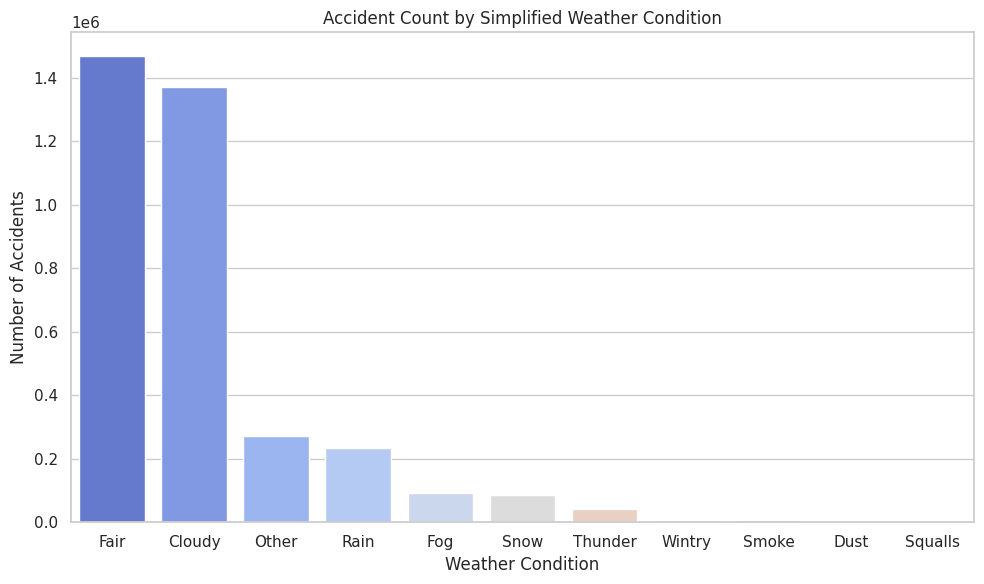

<function gc.collect(generation=2)>

In [18]:
accidents_by_weather = my_df['Weather_Simplified'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_weather.index, y=accidents_by_weather.values, palette="coolwarm")
plt.title("Accident Count by Simplified Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

del accidents_by_weather
gc.collect

#### Classify Precipitation levels according to common precipitation thresholds (based on NOAA guidelines)

In [19]:
# my_df['Precipitation(in)'].value_counts().sort_index()
# my_df['Precipitation_Flag'] = my_df['Precipitation(in)'] > 0

def classify_precip(p):
    if pd.isna(p) or p == 0:
        return 'None'
    elif p < 0.10:
        return 'Light'
    elif p <= 0.30:
        return 'Moderate'
    else:
        return 'Heavy'

my_df['Precipitation_Level'] = my_df['Precipitation(in)'].apply(classify_precip)
my_df = my_df.drop(['Precipitation(in)'], axis=1)

my_df['Precipitation_Level'].value_counts().sort_index()

Precipitation_Level
Heavy         10603
Light        193226
Moderate      42021
None        3336616
Name: count, dtype: int64

-----------------------------------------------------------------------------------------------------------------------------------------

### Date and Time information

In [20]:
# my_df['Date'] = my_df['Start_Time'].dt.normalize()
my_df['Date'] = my_df['Start_Time'].dt.date

my_df['Weekday'] = my_df['Start_Time'].dt.weekday.astype(int)
my_df['Weekday_Name'] = my_df['Start_Time'].dt.day_name()
my_df['Hour'] = my_df['Start_Time'].dt.hour.astype(int)
my_df['Month'] = my_df['Start_Time'].dt.month.astype(int)
my_df['Month_Name'] = my_df['Start_Time'].dt.month_name()
my_df['Is_Weekend'] = my_df['Weekday'].isin([5,6]).astype(bool)

my_df['Is_Night'] = my_df['Sunrise_Sunset'].map({'Night': 1, 'Day': 0}).astype(bool)
my_df = my_df.drop(['Sunrise_Sunset'], axis=1)

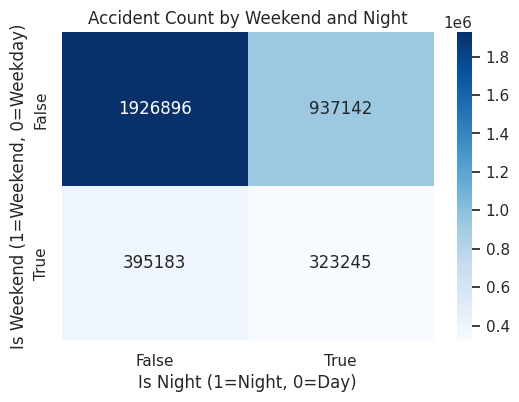

9118

In [21]:
accident_counts = my_df.groupby(['Is_Weekend', 'Is_Night']).size().reset_index(name='Accident_Count')
pivot_table = accident_counts.pivot(index='Is_Weekend', columns='Is_Night', values='Accident_Count')

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Blues")
plt.title('Accident Count by Weekend and Night')
plt.xlabel('Is Night (1=Night, 0=Day)')
plt.ylabel('Is Weekend (1=Weekend, 0=Weekday)')
plt.show()

del accident_counts
del pivot_table
gc.collect()

#### Accidents per day:
Group by date and count accidents.
Plot a time series to check trends (e.g., increasing/decreasing).

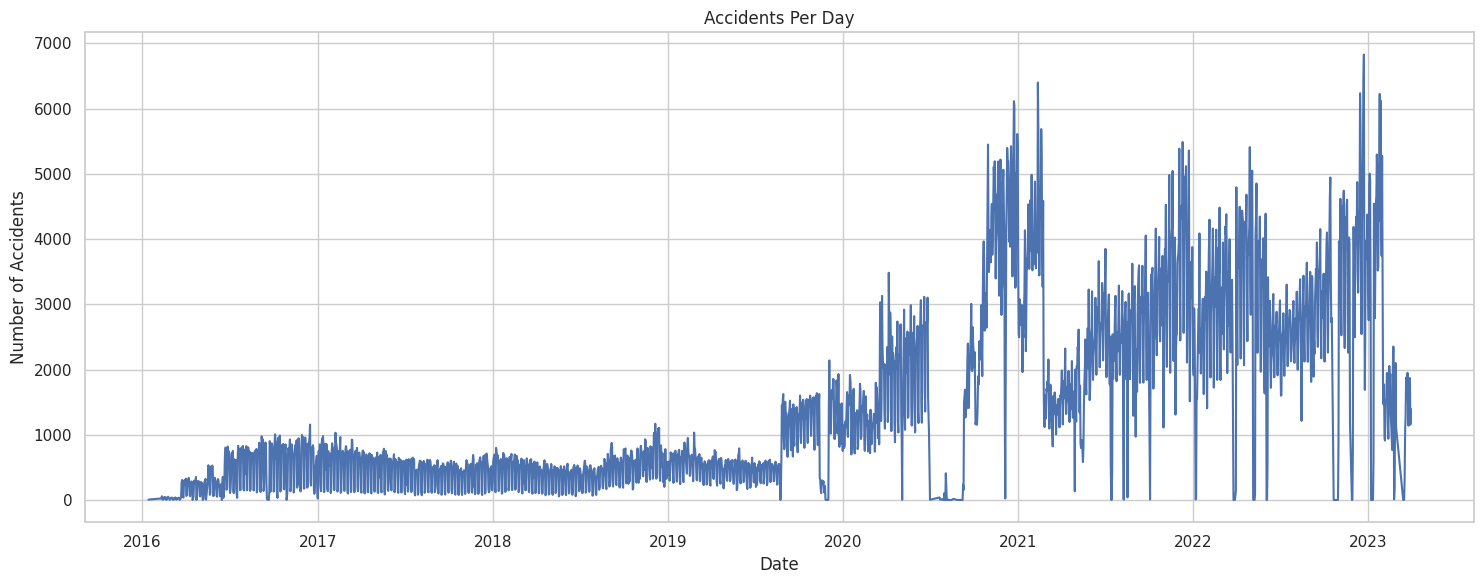

8398

In [22]:
# Group by date and count the number of accidents
accidents_per_day = my_df.groupby('Date').size().reset_index(name='accident_count')

# Plot the time series
plt.figure(figsize=(15, 6))
sns.lineplot(data=accidents_per_day, x='Date', y='accident_count')
plt.title("Accidents Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

del accidents_per_day
gc.collect()

#### Day of week

Are weekends more dangerous than weekdays?

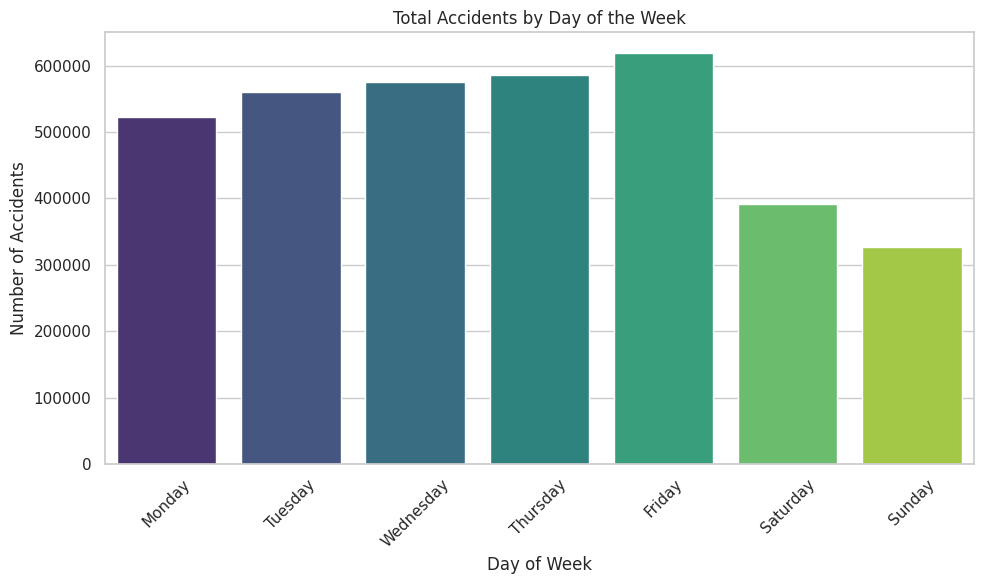

6841

In [23]:
# Group by day name and count number of accidents
accidents_by_weekday = my_df['Weekday_Name'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the result
plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_by_weekday.index, y=accidents_by_weekday.values, palette='viridis')
plt.title("Total Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

del accidents_by_weekday
gc.collect()

-----------------------------------------------------------------------------------------------------------------------------------------

#### Rush hours
Weekday  (Mon–Fri) : 7-9 and 16-18<br>
Weekends (Sat–Sun) : 10-12 and 16-19

In [24]:
def is_workday_rush_hour(hour, weekday):
    hour, weekday = int(hour), int(weekday)
    return (weekday < 5) and ((7 <= hour <= 9) or (16 <= hour <= 18))

def is_weekend_rush_hour(hour, weekday):
    hour, weekday = int(hour), int(weekday)
    return (weekday >= 5) and ((10 <= hour <= 12) or (16 <= hour <= 19))

my_df['Is_Workday_Rush_Hour'] = my_df.apply(lambda row: is_workday_rush_hour(row['Hour'], row['Weekday']), axis=1).astype(int)
my_df['Is_Weekend_Rush_Hour'] = my_df.apply(lambda row: is_weekend_rush_hour(row['Hour'], row['Weekday']), axis=1).astype(int)


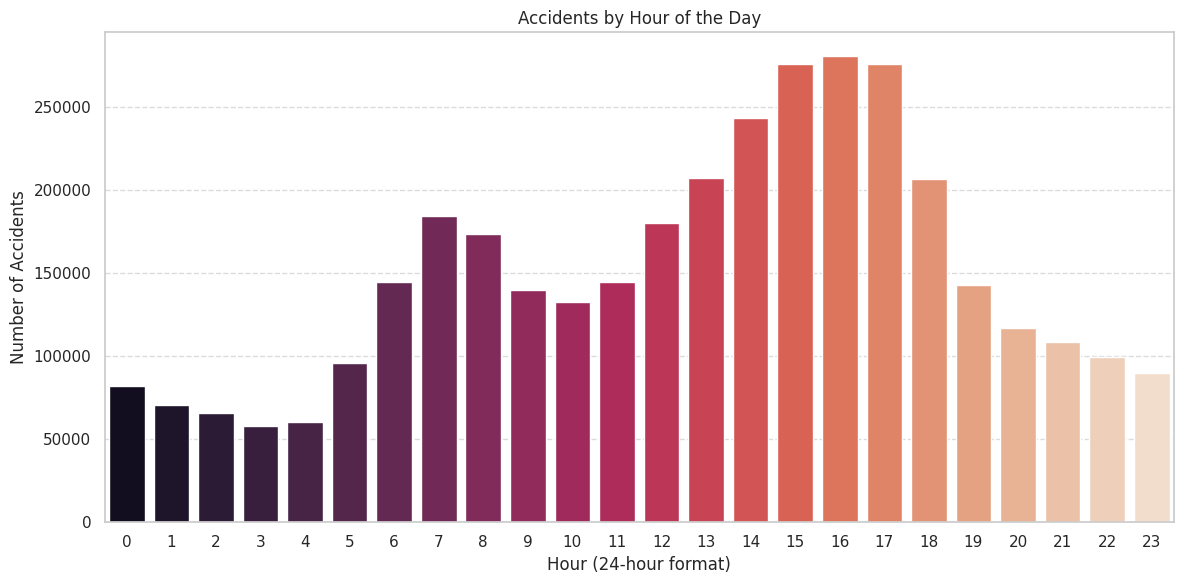

6853

In [25]:
accidents_by_hour = my_df['Hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_by_hour.index, y=accidents_by_hour.values, palette='rocket')
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour (24-hour format)")
plt.ylabel("Number of Accidents")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

del accidents_by_hour
gc.collect()

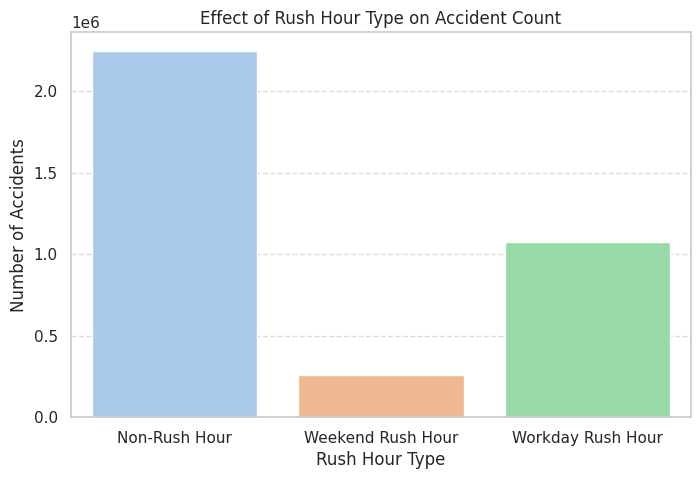

2607

In [26]:
rush_hour_effect = my_df.groupby(['Is_Workday_Rush_Hour', 'Is_Weekend_Rush_Hour']).size().reset_index(name='Accident_Count')
rush_hour_effect['Rush_Hour_Type'] = rush_hour_effect.apply(
    lambda row: 'Workday Rush Hour' if row['Is_Workday_Rush_Hour'] == 1 else (
                'Weekend Rush Hour' if row['Is_Weekend_Rush_Hour'] == 1 else 'Non-Rush Hour'), axis=1)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Rush_Hour_Type', y='Accident_Count', data=rush_hour_effect, palette='pastel')
plt.title('Effect of Rush Hour Type on Accident Count')
plt.ylabel('Number of Accidents')
plt.xlabel('Rush Hour Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

del rush_hour_effect
gc.collect()

-----------------------------------------------------------------------------------------------------------------------------------------

### Accidents per month
check if amount of accidents in specific months are affected more by weather conditions or holidays

In [27]:
us_holidays = holidays.US()
my_df['Is_Holiday'] = my_df['Date'].apply(lambda x: 1 if x in us_holidays else 0).astype(int)
print(my_df.groupby(['Hour', 'Is_Holiday']).size().unstack(fill_value=0))

del us_holidays
gc.collect()

Is_Holiday       0     1
Hour                    
0            78137  3771
1            67203  3565
2            62584  3437
3            55190  2720
4            57934  2492
5            93224  2946
6           141026  3639
7           180760  3883
8           169876  3788
9           135964  3932
10          128033  4415
11          139102  5539
12          174304  6194
13          200772  6676
14          235868  7444
15          268648  7636
16          273686  7345
17          268665  7427
18          200453  6456
19          137859  5264
20          112379  4501
21          103969  4322
22           95970  3748
23           86362  3358


0

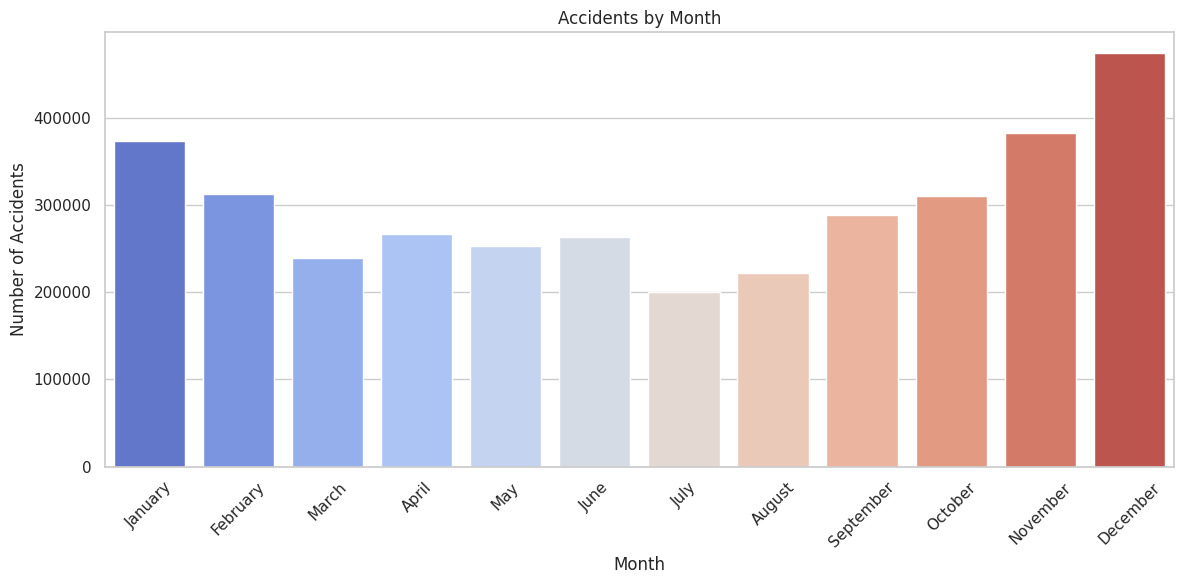

In [28]:
# Group by month name
accidents_by_month = my_df['Month_Name'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=accidents_by_month.index, y=accidents_by_month.values, palette='coolwarm')
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

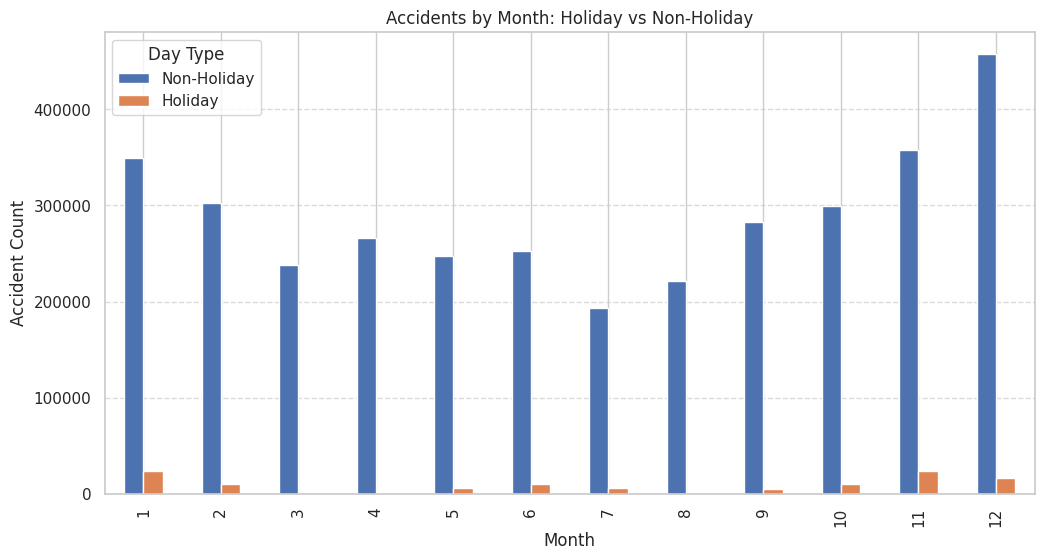

4807

In [29]:
month_holiday = my_df.groupby(['Month', 'Is_Holiday']).size().reset_index(name='Accident_Count')

month_holiday_pivot = month_holiday.pivot(index='Month', columns='Is_Holiday', values='Accident_Count')
month_holiday_pivot.columns = ['Non-Holiday', 'Holiday']

month_holiday_pivot.plot(kind='bar', figsize=(12,6))
plt.title('Accidents by Month: Holiday vs Non-Holiday')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Day Type')
plt.show()

del month_holiday
del month_holiday_pivot
gc.collect()

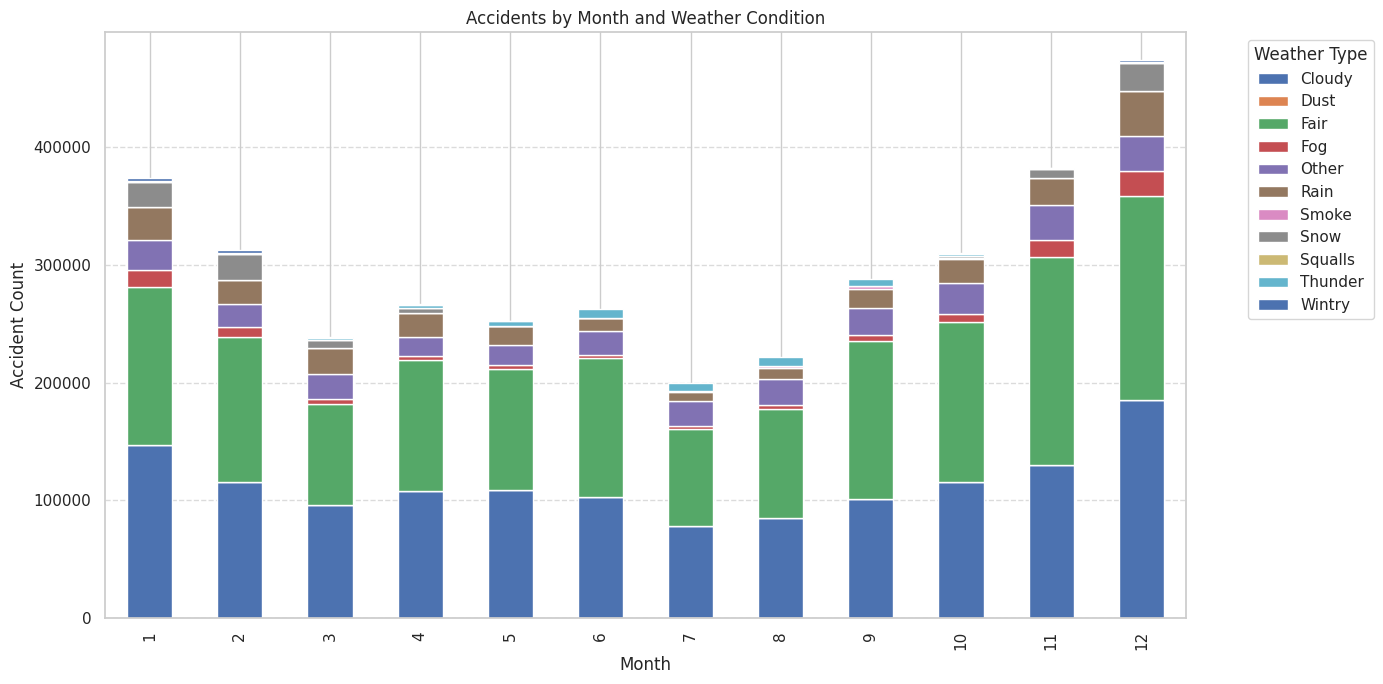

11798

In [30]:
month_weather = my_df.groupby(['Month', 'Weather_Simplified']).size().reset_index(name='Accident_Count')

month_weather_pivot = month_weather.pivot(index='Month', columns='Weather_Simplified', values='Accident_Count')

month_weather_pivot.plot(kind='bar', stacked=True, figsize=(14,7))
plt.title('Accidents by Month and Weather Condition')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.legend(title='Weather Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(14, 8))
# sns.heatmap(month_weather_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
# plt.title('Accident Count by Month and Weather Condition')
# plt.xlabel('Weather Condition')
# plt.ylabel('Month')
# plt.yticks(ticks=range(1,13), labels=[
#     'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
# ], rotation=0)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

del month_weather
del month_weather_pivot
gc.collect()

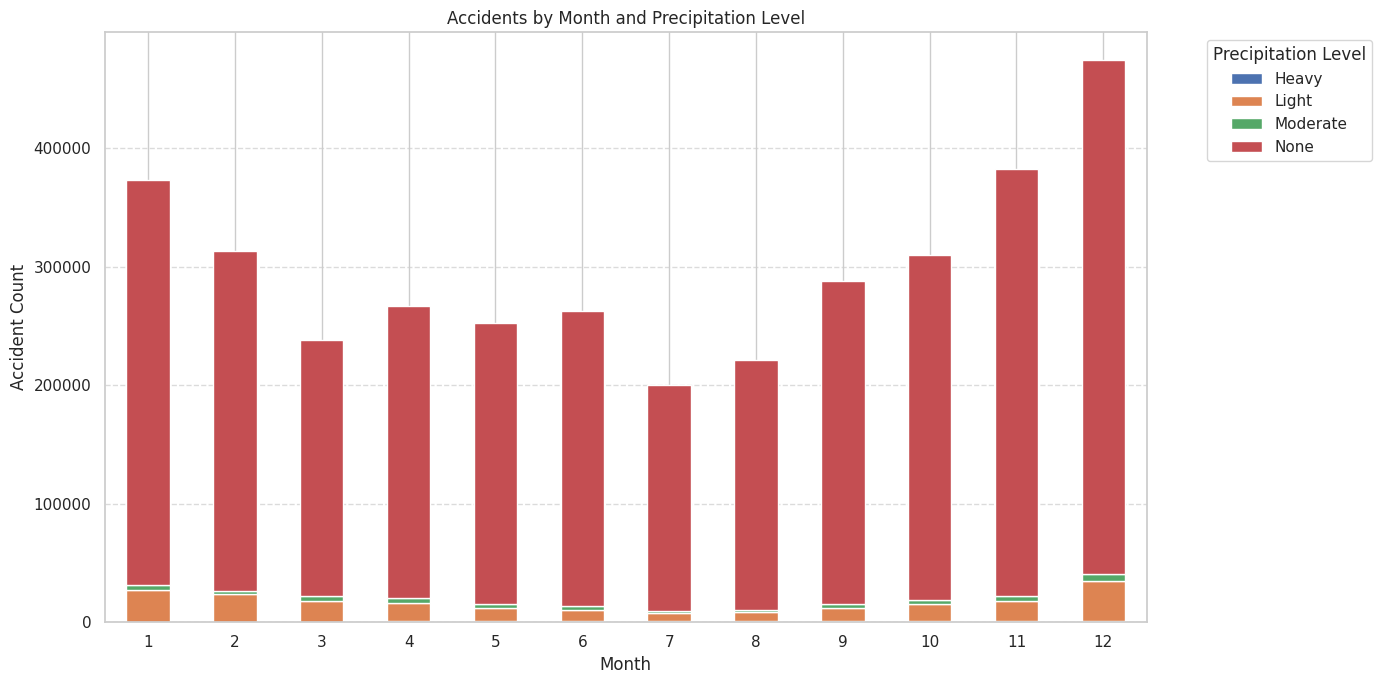

6028

In [31]:
month_precip = my_df.groupby(['Month', 'Precipitation_Level']).size().reset_index(name='Accident_Count')

month_precip_pivot = month_precip.pivot(index='Month', columns='Precipitation_Level', values='Accident_Count').fillna(0)

month_precip_pivot.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Accidents by Month and Precipitation Level')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.legend(title='Precipitation Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

del month_precip
del month_precip_pivot
gc.collect()

-----------------------------------------------------------------------------------------------------------------------------------------

### Which of these "road features" has a bigger impact on the number of accidents?
Might not perdict because affected by commness of the road feature (ex. less railroads than traffic signs)

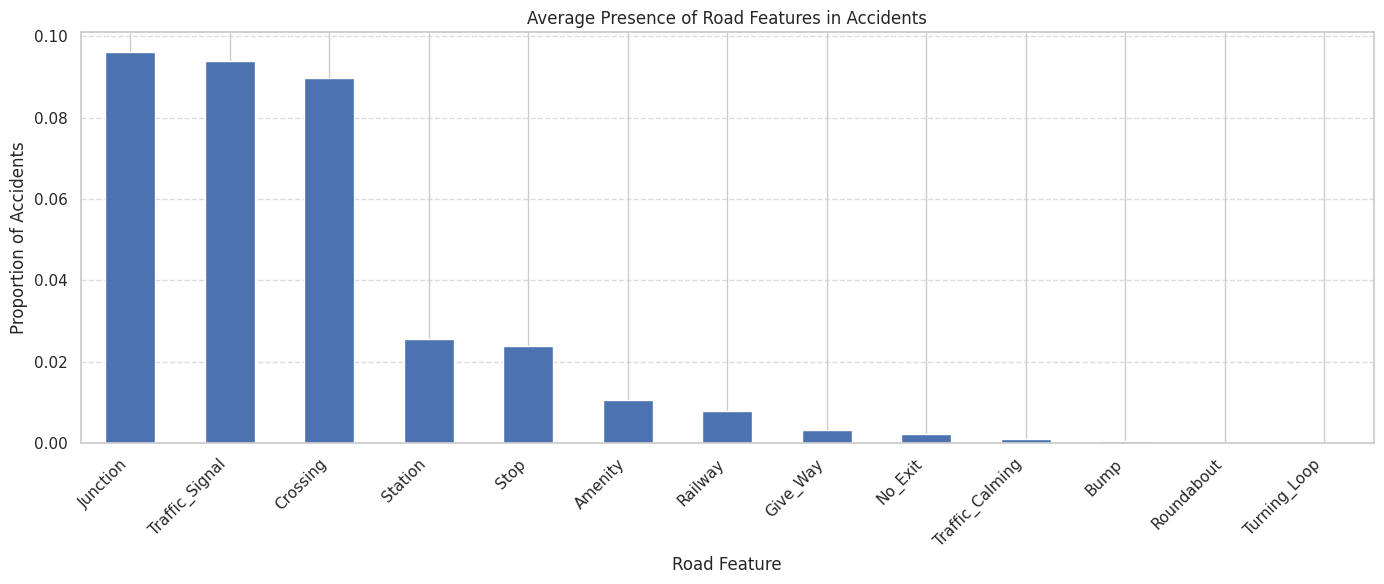

3992

In [32]:
road_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
    'Traffic_Signal', 'Turning_Loop'
]

# Calculate mean accident presence (proportion) when feature = 1
# mean = the feature appears more often in accident locations
feature_effect = my_df[road_features].mean().sort_values(ascending=False)

# Visualize
feature_effect.plot(kind='bar', figsize=(14, 6))
plt.title('Average Presence of Road Features in Accidents')
plt.ylabel('Proportion of Accidents')
plt.xlabel('Road Feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

del feature_effect
gc.collect()

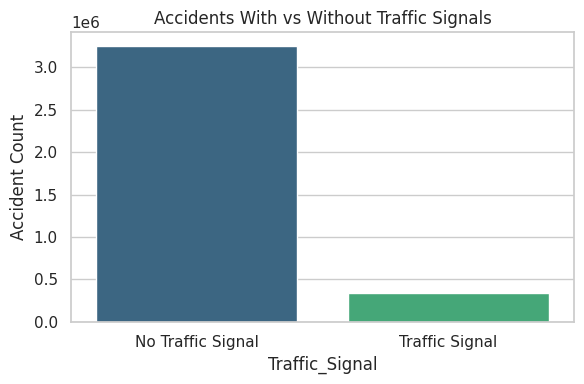

2564

In [33]:
signal_counts = my_df['Traffic_Signal'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=signal_counts.index, y=signal_counts.values, palette='viridis')
plt.xticks([0,1], ['No Traffic Signal', 'Traffic Signal'])
plt.ylabel("Accident Count")
plt.title("Accidents With vs Without Traffic Signals")
plt.tight_layout()
plt.show()

del signal_counts
gc.collect()

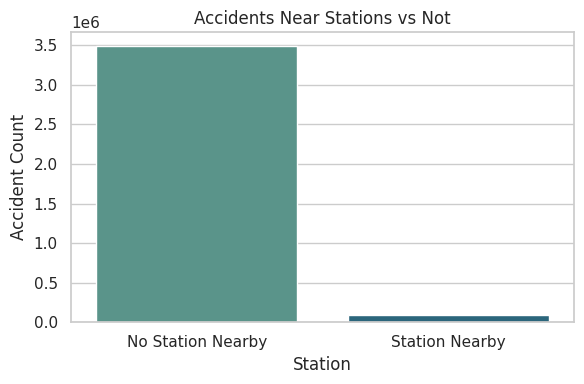

2668

In [34]:
station_counts = my_df['Station'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=station_counts.index, y=station_counts.values, palette='crest')
plt.xticks([0,1], ['No Station Nearby', 'Station Nearby'])
plt.ylabel("Accident Count")
plt.title("Accidents Near Stations vs Not")
plt.tight_layout()
plt.show()

del station_counts
gc.collect()

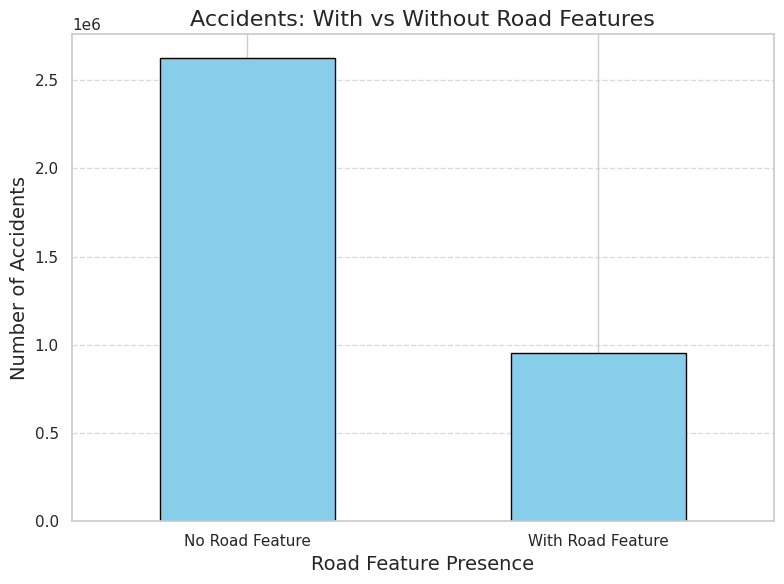

In [35]:
# List of all road feature columns
road_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
]

# Fill NaNs in road features with 0 first
my_df[road_features] = my_df[road_features].fillna(0).astype(int)

# Create a new column: Any_Road_Feature
my_df['Any_Road_Feature'] = my_df[road_features].max(axis=1)

road_feature_counts = my_df.groupby('Any_Road_Feature').size()
road_feature_counts.index = ['No Road Feature', 'With Road Feature']

plt.figure(figsize=(8,6))
road_feature_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Accidents: With vs Without Road Features', fontsize=16)
plt.xlabel('Road Feature Presence', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------

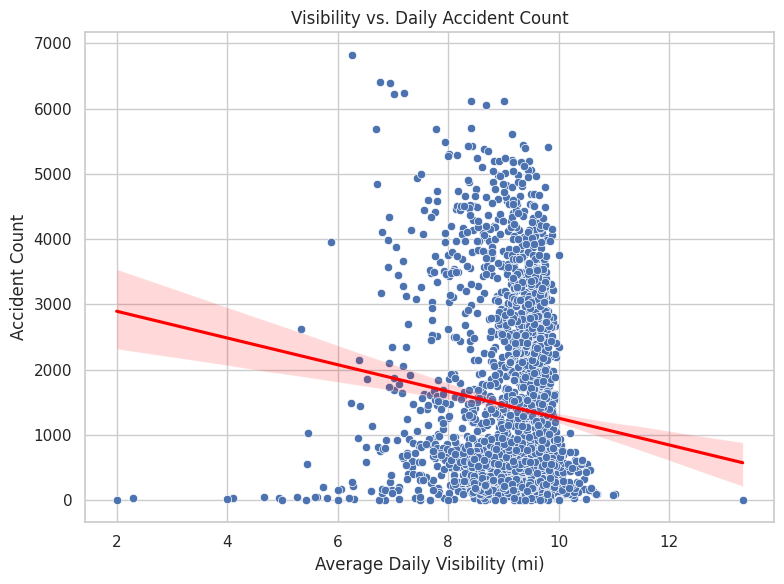

Correlation between Visibility and Accident Count: -0.123


In [36]:
# Group by date and calculate daily stats
daily_df = my_df.groupby('Date').agg({
    'ID': 'count',  # daily accident count
    'Visibility(mi)': 'mean'  # average visibility
}).rename(columns={'ID': 'accident_count'}).reset_index()

# Plotting correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=daily_df, x='Visibility(mi)', y='accident_count')
sns.regplot(data=daily_df, x='Visibility(mi)', y='accident_count', scatter=False, color='red')
plt.title('Visibility vs. Daily Accident Count')
plt.xlabel('Average Daily Visibility (mi)')
plt.ylabel('Accident Count')
plt.tight_layout()
plt.show()

# Calculate and print correlation
correlation = daily_df['Visibility(mi)'].corr(daily_df['accident_count'])
print(f"Correlation between Visibility and Accident Count: {correlation:.3f}")

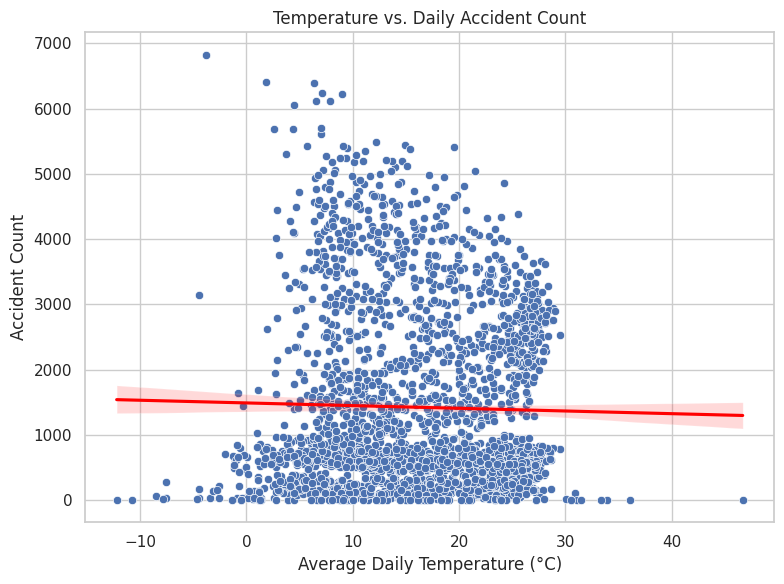

Correlation between Temperature and Accident Count: -0.023


In [37]:
# Make sure Start_Time is datetime and extract date
my_df['Start_Time'] = pd.to_datetime(my_df['Start_Time'])
my_df['date'] = my_df['Start_Time'].dt.date

# Group by date to get daily average temperature and accident count
daily_df = my_df.groupby('date').agg({
    'ID': 'count',  # number of accidents
    'Temperature(C)': 'mean'  # average temperature
}).rename(columns={'ID': 'accident_count'}).reset_index()

# Plot: Temperature vs Accident Count
plt.figure(figsize=(8, 6))
sns.scatterplot(data=daily_df, x='Temperature(C)', y='accident_count')
sns.regplot(data=daily_df, x='Temperature(C)', y='accident_count', scatter=False, color='red')
plt.title('Temperature vs. Daily Accident Count')
plt.xlabel('Average Daily Temperature (°C)')
plt.ylabel('Accident Count')
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = daily_df['Temperature(C)'].corr(daily_df['accident_count'])
print(f"Correlation between Temperature and Accident Count: {correlation:.3f}")

### Correlation between Distance and Severity

Correlation between Distance(km) and Severity: 0.0503


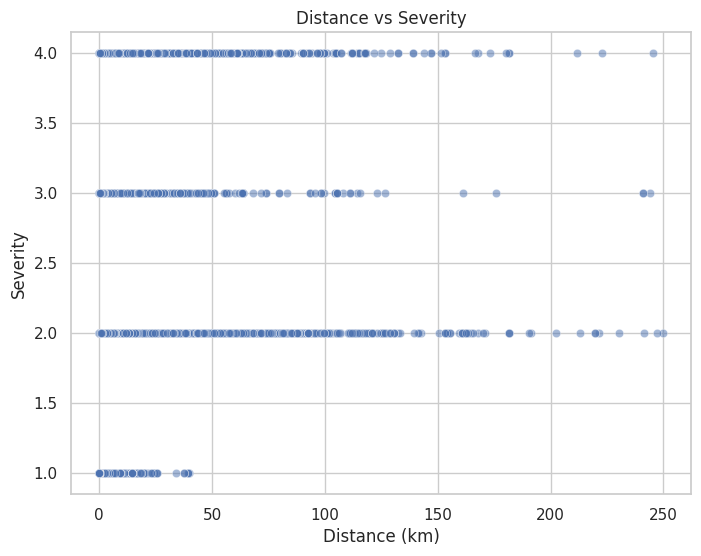

3410

In [38]:
correlation = my_df['Distance(km)'].corr(my_df['Severity'])
print(f'Correlation between Distance(km) and Severity: {correlation:.4f}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Distance(km)', y='Severity', data=my_df, alpha=0.5)
plt.title('Distance vs Severity')
plt.xlabel('Distance (km)')
plt.ylabel('Severity')
plt.grid(True)
plt.show()

del correlation
gc.collect()

# Conclusion: It seems to be a very weak correlation between severity and distance 
# A long accident zone doesn't necessarily mean it's more or less severe.

# -------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------

# Regressions

## Accidents by hour based on features selected by the EDA <br>
#### The EDA revealed that most accidents occur 🚗 <br>
- 📅 **On workdays** (not weekends)
- 🎉 **Not during holidays**
- ☀️ **During daytime hours** (but **not during rush hours**)
- ⛅ **In fair or cloudy weather**
- 🛣️ **When no special road features are present**
<br>
#### Important Context and Limitations<br>
- Accident-Only Data:
The dataset contains only records of accidents.<br>
Therefore, we cannot determine the percentage of all rides that result in accidents under specific weather, road, and temporal conditions.
- No Pre-Accident Trip Information:
We do not have data on trip durations or distances traveled before accidents. <br>
This limits our ability to assess exposure risk based on journey length or time spent on the road.

### Visualize Model Performance
We visualized the performance of each model using scatter plots, comparing the actual accident counts against the predicted counts.
A perfect model would align all points along a 45° line.
These plots help intuitively assess whether models are systematically overestimating or underestimating accident counts.

In [39]:
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Accident Count')
    plt.ylabel('Predicted Accident Count')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

### Encoding and Splitting
Accident counts were aggregated per hour based on these features to form the prediction dataset.

In [40]:
agg_features = ['Hour', 'Is_Weekend', 'Is_Holiday', 'Is_Workday_Rush_Hour', 'Is_Weekend_Rush_Hour', 'Is_Night', 'Weather_Simplified']
# agg_features = ['Hour', 'Is_Weekend', 'Is_Holiday', 'Is_Workday_Rush_Hour', 'Is_Weekend_Rush_Hour', 'Is_Night', 'Weather_Simplified', 'Any_Road_Feature']

hourly_data = my_df.groupby(agg_features).size().reset_index(name='Accident_Count')

# Suppose your hourly accidents data is in `df`
X = hourly_data[['Hour', 'Is_Weekend', 'Is_Holiday', 'Is_Workday_Rush_Hour', 'Is_Weekend_Rush_Hour', 'Is_Night', 'Weather_Simplified']]
y = hourly_data['Accident_Count']

# One-hot encode Weather_Category
X = pd.get_dummies(X, columns=['Weather_Simplified'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building Regression Models

### Model : Linear Regression
Assumes a straight-line relationship between features and accident counts.

Linear Regression MSE: 53627936.498392
Linear Regression R2: 0.29444787033143827


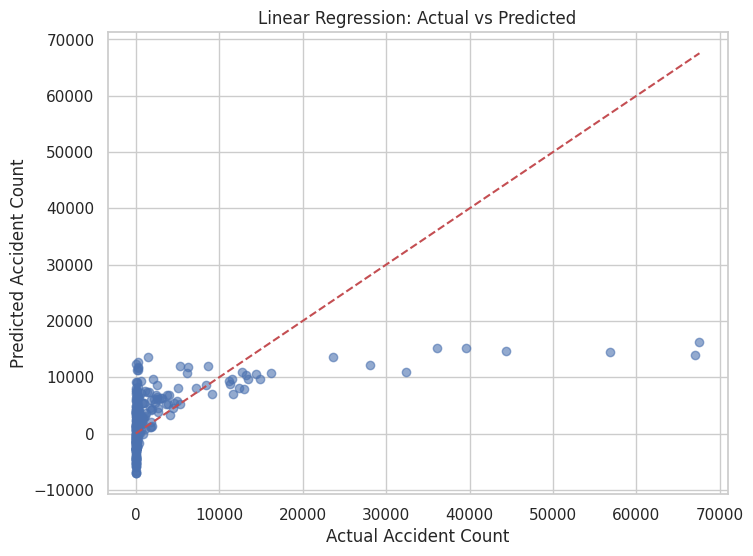

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
print('Linear Regression MSE:', mean_squared_error(y_test, y_pred_lr))
print('Linear Regression R2:', r2_score(y_test, y_pred_lr))
plot_predictions(y_test, y_pred_lr, 'Linear Regression')

### Model : Decision Tree Regression
Learns simple decision rules based on feature values to predict accident counts.

Decision Tree MSE: 8480324.711610487
Decision Tree R2: 0.8884292115036513


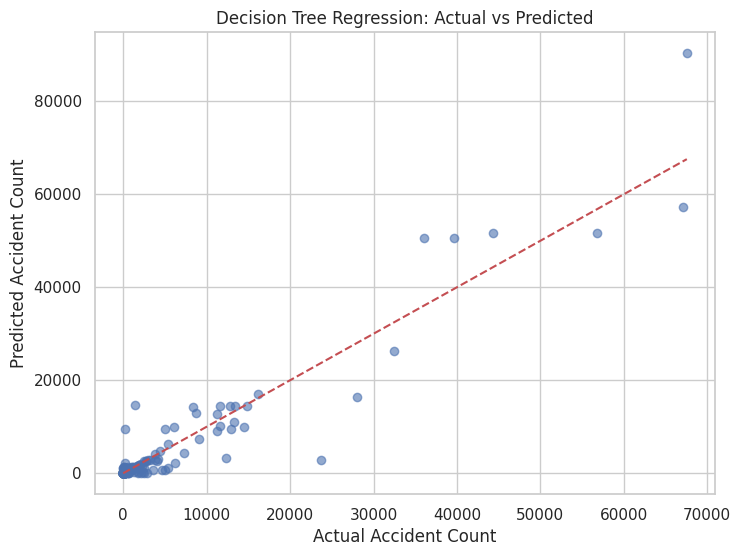

In [42]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)

# Evaluate
print('Decision Tree MSE:', mean_squared_error(y_test, y_pred_dt))
print('Decision Tree R2:', r2_score(y_test, y_pred_dt))
plot_predictions(y_test, y_pred_dt, 'Decision Tree Regression')

#### Hyper-tune Decision Tree : Testing different tree depths to avoid overfitting or underfitting.

Best Decision Tree depth: 14


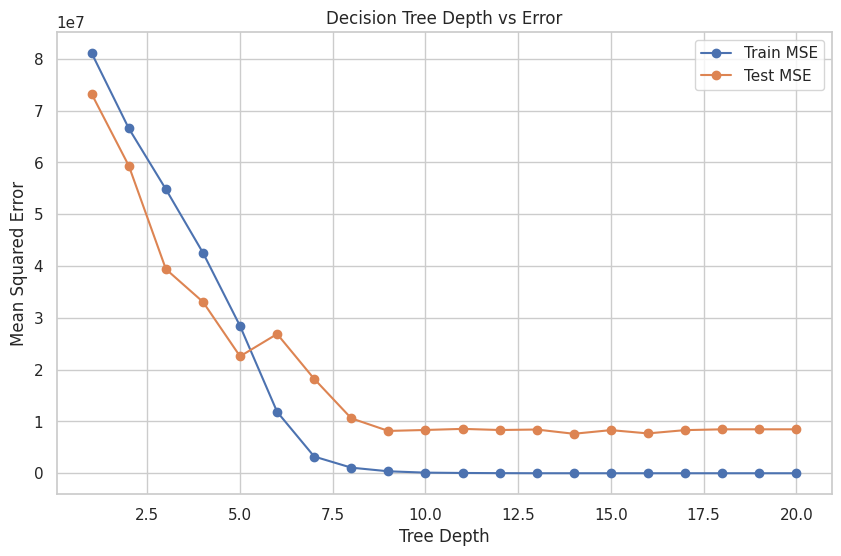

In [43]:
train_errors = []
test_errors = []
depths = range(1, 21)

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Find best depth based on minimum test MSE
optimal_depth = depths[test_errors.index(min(test_errors))]
print(f"Best Decision Tree depth: {optimal_depth}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(depths, train_errors, label='Train MSE', marker='o')
plt.plot(depths, test_errors, label='Test MSE', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Depth vs Error')
plt.legend()
plt.grid(True)
plt.show()

### Model : K-Nearest Neighbors (KNN) Regression
Predicts accident counts based on the average counts of the most similar past conditions.

KNN Regression MSE: 50079060.485842705
KNN Regression R2: 0.34113840500563564


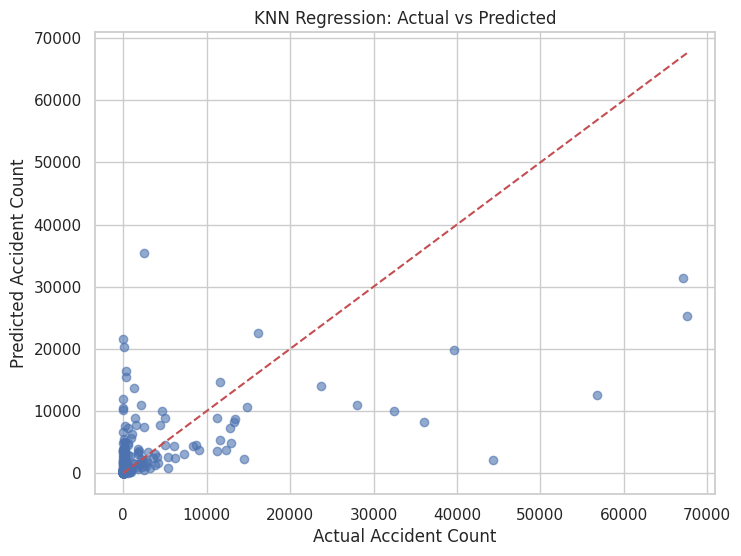

In [44]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate
print('KNN Regression MSE:', mean_squared_error(y_test, y_pred_knn))
print('KNN Regression R2:', r2_score(y_test, y_pred_knn))
plot_predictions(y_test, y_pred_knn, 'KNN Regression')

#### Hyper-tune KNN : Testing different numbers of neighbors (k) to balance bias and variance.

Best K for KNN: 2


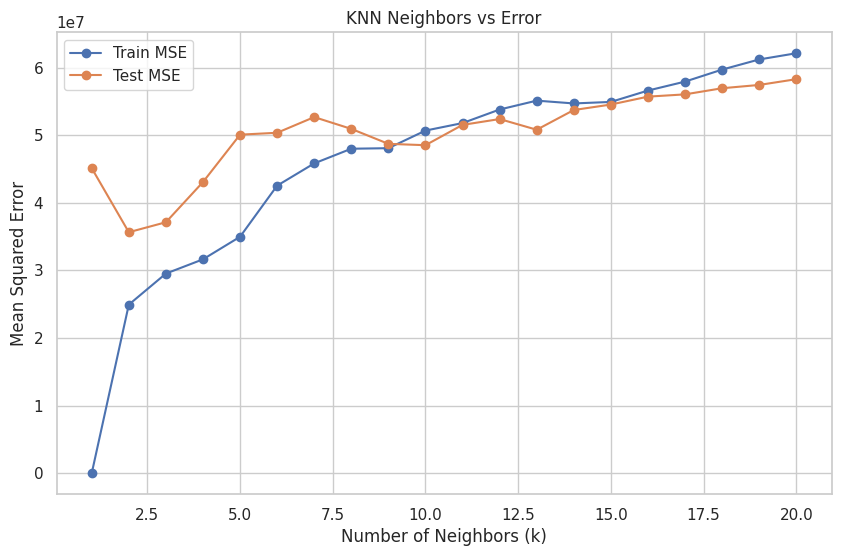

In [45]:
train_errors = []
test_errors = []
neighbors = range(1, 21)

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Find best k based on minimum test MSE
optimal_k = neighbors[test_errors.index(min(test_errors))]
print(f"Best K for KNN: {optimal_k}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(neighbors, train_errors, label='Train MSE', marker='o')
plt.plot(neighbors, test_errors, label='Test MSE', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.title('KNN Neighbors vs Error')
plt.legend()
plt.grid(True)
plt.show()

### Select the Best Model Based on Test MSE
After training and evaluating all models, we compared their Mean Squared Error (MSE) scores.
The model with the lowest test MSE was selected as the best model.

In [46]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'KNN Regression'],
    'MSE': [
        mean_squared_error(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_dt),
        mean_squared_error(y_test, y_pred_knn)
    ],
    'R2 Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_knn)
    ]
})

print (results)

# First, gather all models and their test MSE
models = {
    'Linear Regression': y_pred_lr,
    'Decision Tree Regression': y_pred_dt,
    'KNN Regression': y_pred_knn
}

mse_scores = {model_name: mean_squared_error(y_test, preds) for model_name, preds in models.items()}

# Find the best model (lowest MSE)
best_model_name = min(mse_scores, key=mse_scores.get)

print(f"✅ Best model based on Test MSE is: {best_model_name}")

# Refit the best model on the FULL dataset if you want
if best_model_name == 'Linear Regression':
    best_model = LinearRegression()
elif best_model_name == 'Decision Tree Regression':
    best_model = DecisionTreeRegressor(random_state=42, max_depth=optimal_depth)  # optional: use optimal depth
elif best_model_name == 'KNN Regression':
    best_model = KNeighborsRegressor(n_neighbors=optimal_k)  # optional: use optimal k

# Fit on ALL data (training + testing)
best_model.fit(X, y)

               Model           MSE  R2 Score
0  Linear Regression  5.362794e+07  0.294448
1      Decision Tree  8.480325e+06  0.888429
2     KNN Regression  5.007906e+07  0.341138
✅ Best model based on Test MSE is: Decision Tree Regression


DecisionTreeRegressor(max_depth=14, random_state=42)

## 📈 Model Performance Before and After Adding `Any_Road_Feature`

We compared model performances before and after including a new feature, `Any_Road_Feature`, which indicates whether any road infrastructure was present near the accident.

### 📊 Quick Summary of Results

|                         | Without `Any_Road_Feature` | With `Any_Road_Feature` |
|-------------------------|----------------------------|--------------------------|
| **Best Model**          | Decision Tree (R² = 0.888) | KNN Regression (R² = 0.449) |
| **Linear Regression**   | Weak fit (R² ≈ 0.29)        | Weaker fit (R² ≈ 0.18)   |
| **Decision Tree**       | Very strong fit (possible overfitting) | Much weaker fit |
| **KNN Regression**      | Moderate fit (R² ≈ 0.34)    | Slightly better fit (R² ≈ 0.45) |

---

### 📈 Detailed Performance Metrics

| Model                | MSE (Before) | R² (Before) | MSE (After) | R² (After) |
|----------------------|--------------|-------------|-------------|------------|
| Linear Regression    | 53,627,940   | 0.294       | 18,360,040  | 0.184      |
| Decision Tree        | 8,480,325    | 0.888       | 13,460,870  | 0.402      |
| KNN Regression       | 50,079,060   | 0.341       | 12,412,110  | 0.449      |

---

### Key Observations:
- **Decision Tree Regression** initially showed the highest R² score (0.888), suggesting a strong fit to the original features.
- After adding `Any_Road_Feature`, **KNN Regression** achieved the best performance with an R² of **0.449**.
- Including `Any_Road_Feature` slightly improved KNN's ability to generalize, although overall R² scores decreased due to model rebalancing.

This suggests that road features contribute valuable information but also introduce more complexity into the prediction task.
